In [1]:
from os import walk

# load the train images and their relative paths
visdial_val_images = "../data/v1.0/VisualDialog_val2018/"
val_images = next(walk(visdial_val_images), (None, None, []))[
    2]  # gives [] if no file
# add relative path to each file name
val_images = list(
    map(lambda orig_string: visdial_val_images + orig_string, val_images))


In [2]:
len(val_images)

2064

In [3]:
import json
import numpy as np
from tqdm import tqdm
from time import sleep
from PIL import Image

# set the data subset to use
subset = 1
# load the subset of the dataset
data = json.load(
    open('../github/visdial/datasets/annotations/visdial_1.0_val.json'))['data']
dialogs = data['dialogs']
# note: image id 746 is a black and white image with no rgb channels
image_paths = [index['image_id'] for index in data['dialogs']]

In [4]:
len(dialogs), len(image_paths)

(2064, 2064)

In [4]:
# find the coco_train_val item which contains the string str(image_paths[0])

for i in val_images:
    if str(image_paths[0]) in i:
        print(i)

../data/v1.0/VisualDialog_val2018/VisualDialog_val2018_000000185565.jpg


In [9]:
s = '../data/v1.0/VisualDialog_val2018/VisualDialog_val2018_000000185565.jpg'
# trim the last 4 characters
s[:-4]
# now print the last 6 characters from the remaining string
s[:-4][-6:]


'185565'

In [10]:
from tqdm import tqdm

new_image_paths = []
# replacing the image id with the relative path
for im_path in tqdm(image_paths):
    for i in val_images:
        if im_path == int(i[:-4][-6:]):
            new_image_paths.append(i)

100%|██████████| 2064/2064 [00:01<00:00, 1557.21it/s]


In [11]:
len(new_image_paths), new_image_paths[0]

(2064,
 '../data/v1.0/VisualDialog_val2018/VisualDialog_val2018_000000185565.jpg')

In [15]:
image_paths = new_image_paths

In [16]:
# load the images
images = [Image.open(image_path) for image_path in tqdm(image_paths)]

100%|██████████| 2064/2064 [00:00<00:00, 5457.78it/s]


In [17]:
len(images), images[0]

(2064, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>)

In [19]:
'''Instance segmentation for all images in the subset dataset
Mask R-CNN is used in this case with ResNet-50-FPN backbone'''
# import some common detectron2 utilities, some image processing libraries, and setup detectron2 logger
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import torch
import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.logger import setup_logger
setup_logger()
%matplotlib inline

'''Takes in pred_boxes Box tensors and converts them to a list of integer [x, y, x_width, y_height] (where the order of the list is maintained while creation) for cropping the image'''
def int_box_coordinates(pred_boxes):
    box_coordinates = []
    for pred_box in pred_boxes:
        # x,y is the top left corner of the box and x_width, y_height is the bottom right corner of the box
        # print(pred_box.cpu().numpy()[0])
        box_coordinates.append([int(pred_box.cpu().numpy()[0]),
                                int(pred_box.cpu().numpy()[1]),
                                int(pred_box.cpu().numpy()[2]),
                                int(pred_box.cpu().numpy()[3])])
    return box_coordinates


'''Takes in an image path and returns a list of [x:y, x_width:y_height] based on all the image segments from a detectron2 model'''
def instance_segmentation(image_path):
    # load the image from the path provided
    img = cv2.imread(image_path)
    # create a configuration for the model
    cfg = get_cfg()
    # batch size of 10
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 2
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    # cfg.MODEL.DEVICE = "cpu"  # because I don't have a local GPU
    predictor = DefaultPredictor(cfg)
    outputs = predictor(img)
    # look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
    pred_boxes = outputs["instances"].pred_boxes
    return int_box_coordinates(pred_boxes)

# run the instance segmentation on the images
instance_boxes = [instance_segmentation(image_path) for image_path in tqdm(image_paths)]

100%|██████████| 2064/2064 [29:09<00:00,  1.18it/s]


In [20]:
# save the instance segments on the subset_data
with open('../embeddings/images/instance/'+ str(subset) +'/res50_bounding_boxes_val.json', 'w') as outfile:
    json.dump(instance_boxes, outfile)

# note that the order of the coordinates are x, y, x_width, y_height

In [21]:
import json
import numpy as np
from tqdm import tqdm
from time import sleep

# load the instance segments on the subset_data
instance_boxes = json.load(open('../embeddings/images/instance/'+ str(subset) +'/res50_bounding_boxes_val.json'))

In [22]:
# https://codereview.stackexchange.com/questions/31352/overlapping-rectangles
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y


class Rect(object):
    def __init__(self, p1, p2):
        '''Store the top, bottom, left and right values for points 
               p1 and p2 are the (corners) in either order
        '''
        self.left = min(p1.x, p2.x)
        self.right = max(p1.x, p2.x)
        self.bottom = min(p1.y, p2.y)
        self.top = max(p1.y, p2.y)

    @staticmethod
    def overlap(r1, r2):
        '''Overlapping rectangles overlap both horizontally & vertically
        '''
        h_overlaps = (r1.left <= r2.right) and (r1.right >= r2.left)
        v_overlaps = (r1.bottom <= r2.top) and (r1.top >= r2.bottom)
        return h_overlaps and v_overlaps


In [23]:
[len(i) for i in instance_boxes].count(0)
# seems like there's 10 items with no instance segments


30

In [24]:
# indices of the items with no instance segments
print(list(np.where(np.array([len(i) for i in instance_boxes]) == 0)[0]))

[40, 53, 104, 133, 192, 260, 287, 336, 379, 406, 411, 553, 617, 684, 792, 861, 984, 1015, 1023, 1188, 1189, 1224, 1438, 1562, 1603, 1692, 1793, 1800, 1923, 1960]


In [25]:
instance_boxes[15]

[[33, 327, 108, 407],
 [117, 379, 554, 469],
 [461, 136, 564, 382],
 [319, 144, 346, 167],
 [0, 198, 628, 523],
 [236, 267, 440, 388],
 [422, 149, 446, 173],
 [286, 146, 307, 164],
 [589, 166, 619, 193],
 [311, 145, 352, 167],
 [503, 102, 569, 141],
 [362, 131, 400, 146],
 [204, 136, 258, 153],
 [293, 144, 340, 166],
 [104, 257, 280, 334],
 [89, 128, 113, 149]]

In [26]:
edge_list = []
for image_instances in tqdm(instance_boxes):  # n segments for each image
    interactions = []
    # apparently there are some images with no instance segments
    if len(image_instances) != 0:
        # initialize with the first interaction as a list
        interactions_list = [image_instances[0]]
    for instance in image_instances[1:]:  # n-1 interactions for each image
        for each_interaction in interactions_list:
            # check if the current interaction overlaps with any of the previous interactions
            # note that the order of the coordinates from the list are y:y_height, x:x_width
            l1 = Point(instance[0], instance[1])
            r1 = Point(instance[2], instance[3])
            l2 = Point(each_interaction[0], each_interaction[1])
            r2 = Point(each_interaction[2], each_interaction[3])
            # if it does, add an edge between the two where edge index is based on its position in the image_instances list
            if Rect.overlap(Rect(l1, r1), Rect(l2, r2)):
                # the edges are undirected so we add both directions
                interactions.append([image_instances.index(
                    each_interaction), image_instances.index(instance)])
                interactions.append([image_instances.index(
                    instance), image_instances.index(each_interaction)])
            # print("Checking between", [image_instances.index(each_interaction), image_instances.index(instance)])
        # append the current interaction to the interactions_list
        interactions_list.append(instance)
    edge_list.append(interactions)

# save the instance segments on the subset_data
with open('../embeddings/images/instance/' + str(subset) + '/res50_edge_list_val.json', 'w') as outfile:
    json.dump(edge_list, outfile)


100%|██████████| 2064/2064 [00:00<00:00, 4734.97it/s]


In [27]:
adj_matrix = []
for element in edge_list:
    # size here is
    size = len(instance_boxes[edge_list.index(element)])
    # initialize adjacency matrix
    adj_matrix_element = [[0 for i in range(size)] for j in range(size)]
    # add edges to the adjacency matrix
    if len(element) != 0:
        for row, col in element:
            adj_matrix_element[row][col] = 1
    # add the adjacency matrix to the list of adjacency matrices
    adj_matrix.append(adj_matrix_element)


# save the instance segments on the subset_data
with open('../embeddings/images/instance/'+ str(subset) +'/res50_adj_list_val.json', 'w') as outfile:
    json.dump(adj_matrix, outfile)

In [28]:
# open the edge_list of the instance segments on the subset_data
edge_list = json.load(open('../embeddings/images/instance/'+ str(subset) +'/res50_edge_list_val.json'))

In [29]:
# open the adj_matrix of the instance segments on the subset_data
adj_matrix = json.load(open('../embeddings/images/instance/'+ str(subset) +'/res50_adj_list_val.json'))

In [30]:
# crop the images based on the instance segments where each instance segment is represented by a 2048-dim vector
# note that the order of the coordinates from the list are y:y_height, x:x_width
from PIL import Image
from IPython.display import display
import numpy as np
from tqdm import tqdm

images = [Image.open(image_path) for image_path in image_paths]

# crop the images based on the instance segments
instance_segments = []
for image, image_instances in zip(tqdm(images), instance_boxes):
    # apparently there are some images with no instance segments
    for_each_image = []
    if len(image_instances) != 0:
        for instance in image_instances:
            # note that the order of the coordinates from the list are y:y_height, x:x_width
            for_each_image.append(np.array(image.crop(
                (instance[0], instance[1], instance[2], instance[3]))))
    else:
        for_each_image.append(np.array(image.crop((0, 0, 0, 0))))
    instance_segments.append(for_each_image)

100%|██████████| 2064/2064 [00:12<00:00, 164.78it/s]


In [31]:
# pad an np array with zeros to make it 224x224 if the image is smaller than 224x224
def pad_or_crop(image):
    if image.shape[0] < 224 and image.shape[1] < 224:
        image = np.pad(
            image, ((0, 224 - image.shape[0]), (0, 224 - image.shape[1]), (0, 0)), 'constant')
    elif image.shape[0] < 224 and image.shape[1] >= 224 or image.shape[0] >= 224 and image.shape[1] < 224:
        image = image = image[:224, :224, :]
        image = np.pad(
            image, ((0, 224 - image.shape[0]), (0, 224 - image.shape[1]), (0, 0)), 'constant')
    else:
        image = image[:224, :224, :]
    return image


pad_or_crop(np.zeros((250, 22, 3))).shape

(224, 224, 3)

In [32]:
# converting a greyscale image to rgb
np.stack((Image.open(image_paths[746]),)*3, axis=-1).shape

(640, 480, 3, 3)

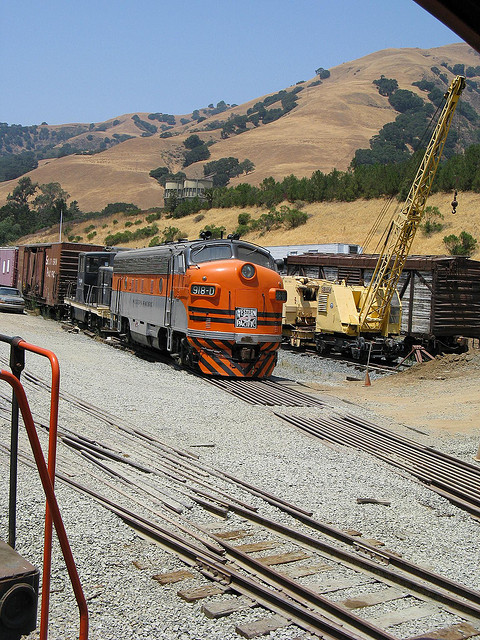

In [33]:
'''Display an image given its path.'''
from IPython.display import display
from PIL import Image

def display_image(image_path):
    display(Image.open(image_path))

# seemed to be the problem: didn't convert the greyscale image to rgb
display_image(image_paths[746])

100%|██████████| 2064/2064 [00:02<00:00, 958.14it/s] 


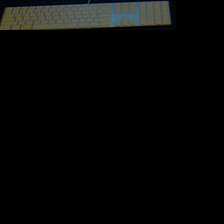

In [34]:
# check dimension of the cropped images: if dimension is less than 224x224, pad the image ndarray with zeros, else crop the image ndarray to 224x224
all_segments = []
flag = 0
for image in tqdm(instance_segments):
    segments = []
    for instance in image:
        # check if shape is 2d, if so, convert to rgb
        if len(instance.shape) == 2: # if the image is greyscale
            instance = np.stack((instance,)*3, axis=-1)

        # do the padding or cropping    
        if len(instance) != 0: # where image segments have been detected
            segments.append(pad_or_crop(instance))
        else: # where no image segments have been detected
            segments.append(pad_or_crop(np.zeros((224, 224, 3), dtype=np.uint8))) # initialize with np array of zeros with dtype uint8 (since it's an image)
    all_segments.append(segments)

Image.fromarray(np.array(all_segments[0][1]), 'RGB')

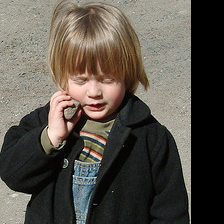

In [35]:
Image.fromarray(np.array(all_segments[14][0]), 'RGB')

In [36]:
# input an image of shape 224x224x3 and output the 2048-dim vector from the last layer of the resnet50 model
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

# load the resnet50 model
resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# remove the last layer of the resnet50 model
resnet50 = torch.nn.Sequential(*(list(resnet50.children())[:-1]))
# set the model to evaluation mode
resnet50.eval()

# input an image of shape 224x224x3 and output the 2048-dim vector from the last layer of the resnet50 model
def get_vector(image):
    # convert the image to a tensor
    tensor = transforms.ToTensor()(image)
    # add a batch dimension to the tensor
    tensor = tensor.unsqueeze(0)
    # convert the tensor to a pytorch variable
    tensor = Variable(tensor)
    # get the 2048-dim vector from the last layer of the resnet50 model
    vector = resnet50(tensor)
    # flatten the vector
    vector = vector.view(vector.size(0), -1)
    # return the vector
    return vector

# testing the get_vector function
get_vector(Image.fromarray(np.array(all_segments[0][1]), 'RGB')).shape

# store the 2048-dim vectors for all the instance segments
instance_vectors = []
for image in tqdm(all_segments):
    instance_vectors.append([get_vector(instance).detach().numpy() for instance in image])

100%|██████████| 2064/2064 [09:44<00:00,  3.53it/s]


In [ ]:
# convert the list of lists to a list of np arrays
[np.array(image) for image in instance_vectors][14].squeeze(0).shape
[np.array(image) for image in instance_vectors][13].squeeze().shape
[np.array(image) for image in instance_vectors][13].shape[0]

In [38]:
'''Save the instance vectors to a pickle file.'''
import pickle

# squeeze the instance_vectors to remove the batch dimension of 1
instance_vectors = [np.array(instance) for instance in instance_vectors]

reshaped_instance_vectors = []
for image in instance_vectors:
    if image.shape[0] == 1:
        image = np.squeeze(image, axis=0)
    else:
        image = image.squeeze()
    reshaped_instance_vectors.append(image)

with open('../embeddings/images/instance/'+ str(subset) +'/res50_instance_vectors_val.pkl', 'wb') as f:
    pickle.dump(reshaped_instance_vectors, f)

In [39]:
'''Load the instance vectors from a pickle file.'''
import pickle

# set the subset number
subset = 1
with open('../embeddings/images/instance/'+ str(subset) +'/res50_instance_vectors_val.pkl', 'rb') as f:
    instance_vectors = pickle.load(f)

In [40]:
instance_vectors[0].shape

(7, 2048)

In [41]:
'''Data Formatting Method:
    - shape of each instance_vector should be 36x2048: 36 instances per image, 2048-dim vector per instance
    If there are less than 36 instances in an image, pad the instance_vectors with zeros, else crop the instance_vectors to 36 instances.
    - edge list should also be refactored to contain only the nodes that are less than 36'''

padded_instance_vectors = []
for instance_vector in tqdm(instance_vectors):
    # convert the instance_vector to a list of 2048-dim vectors
    instance_vector = instance_vector.tolist()
    # pad the instance_vector with zeros if there are less than 36 instances
    if len(instance_vector) < 36:
        instance_vector.extend([[0]*2048]*(36-len(instance_vector)))
    # else crop the instance_vector to 36 instances
    else:
        instance_vector = instance_vector[:36]
    # convert the instance_vector to a numpy array
    instance_vector = np.array(instance_vector)
    # append the instance_vector to the padded_instance_vectors list
    padded_instance_vectors.append(instance_vector)

# for each item in the edge list, if a node is less than 20, keep it, otherwise, discard it
edge_list_padded = []
for edge_list_entry in edge_list:
    edge_list_padded_entry = []
    for edge in edge_list_entry:
        if edge[0] < 36 and edge[1] < 36:
            edge_list_padded_entry.append(edge)
    edge_list_padded.append(edge_list_padded_entry)

100%|██████████| 2064/2064 [00:11<00:00, 183.11it/s]


In [42]:
'''Intialize the graph with pytorch geometric'''
from torch_geometric.data import Data

'''Create a list of Data objects for each question where:
    - x is the instance_vectors
    - edge_index is the edge list where they are contiguous'''

image_graphs = []
for i in tqdm(range(len(instance_vectors))):
    image_graphs.append(Data(x=torch.FloatTensor(np.array(padded_instance_vectors[i])), edge_index=torch.LongTensor(edge_list_padded[i]).t().contiguous()))

'''Save the Data objects to a file'''
import pickle

with open('../embeddings/images/instance/' + str(subset) + '/image_graphs_val.pkl', 'wb') as f:
    pickle.dump(image_graphs, f)

100%|██████████| 2064/2064 [00:00<00:00, 3808.81it/s]


In [43]:
'''Load the Data objects from a file'''
import pickle

# set the subset number
subset = 1
with open('../embeddings/images/instance/' + str(subset) + '/image_graphs_val.pkl', 'rb') as f:
    image_graphs = pickle.load(f)
image_graphs[0].view()

AttrView(store=Data(x=[36, 2048], edge_index=[2, 2]), attr=DataTensorAttr(group_name=None, attr_name=<FieldStatus.UNSET: 1>, index=<FieldStatus.UNSET: 1>))

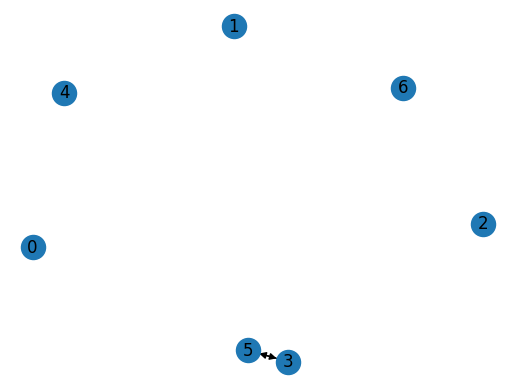

<Figure size 400x400 with 0 Axes>

In [44]:
'''Visualize the graph'''
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(graph):
    G = to_networkx(graph)
    # get a list of nodes in G where the corresponding node in the data object node is zero
    zero_nodes = [node for node in G.nodes if graph.x[node].sum() == 0]
    # remove the zero nodes from G
    G.remove_nodes_from(zero_nodes)
    # initialize the figure and axes | Note: This somehow gets around the "TypeError: '_AxesStack' object is not callable"
    fig, ax = plt.subplots() 
    # draw the graph
    nx.draw(G, ax=ax, with_labels=True)
    # set the figure size 4x4
    plt.figure(figsize=(4, 4))

visualize_graph(image_graphs[0])

In [45]:
# Progress bar
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Torchvision
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl


class GATLayer(nn.Module):

    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(
            num_heads, 2 * c_out))  # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        # Returns indices where the adjacency matrix is not 0 => edges
        edges = adj_matrix.nonzero(as_tuple=False)
        node_feats_flat = node_feats.view(
            batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:, 0] * num_nodes + edges[:, 1]
        edge_indices_col = edges[:, 0] * num_nodes + edges[:, 2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat,
                               index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat,
                               index=edge_indices_col, dim=0)
        ], dim=-1)  # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(
            adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[..., None].repeat(
            1, 1, 1, self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

In [46]:
'''For each question graph, convert the edge list into an adjacency matrix which now captures the updated padded node sizes.'''
adj_list_padded = []

for graph in image_graphs:
    # Get the edge list and transpose it
    edge_list = graph.edge_index.t()
    # Get the number of nodes in the graph
    num_nodes = graph.num_nodes
    # initialize the adjacency matrix for the graph
    adj_matrix_graph = [[0 for i in range(num_nodes)]
                        for j in range(num_nodes)]
    if len(edge_list) != 0:
        for row, col in edge_list:
            # if row and col are greater than 20, the we ignore them
            if row < 20 and col < 20:
                adj_matrix_graph[row][col] = 1
    adj_list_padded.append(adj_matrix_graph)

'''Save the adjacency matrices in a json file'''
with open('../embeddings/images/instance/' + str(subset) + '/adj_list_padded_val.json', 'w') as f:
    json.dump(adj_list_padded, f)


In [47]:
import json 

# open the adjacency matrices
with open('../embeddings/images/instance/' + str(subset) + '/adj_list_padded_val.json', 'r') as f:
    adj_list_padded = json.load(f)

In [48]:
'''Initialize the GAT layer with:
- input dimension of 2048 (the dimensionality of the node features)
- output dimension of 512 (the dimensionality of the output features)
- 4 attention heads
- attention heads are not concatenated
- alpha is set to 0.2
Note: The features here are set from the GoG Paper'''

gat_layer = GATLayer(c_in=2048, c_out=512, num_heads=4, concat_heads=False, alpha=0.2)

# test the GAT layer with the first graph
with torch.no_grad():
    out_feats = gat_layer(node_feats=image_graphs[0].x.clone().detach().unsqueeze(0), adj_matrix=torch.tensor([adj_list_padded[0]]), print_attn_probs=False)

print(image_graphs[0].x.squeeze().shape)
print(out_feats.squeeze().shape)

torch.Size([36, 2048])
torch.Size([36, 512])


In [49]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import pickle

'''Do this for all Image Graphs and save it to the Image Graph Attention List'''
image_gat = image_graphs.copy()

for i in tqdm(range(len(image_graphs))):
    with torch.no_grad():
        out_feats = gat_layer(node_feats=image_graphs[i].x.clone().detach().unsqueeze(0), adj_matrix=torch.tensor([adj_list_padded[i]]), print_attn_probs=False)
    image_gat[i].x = out_feats.squeeze()

'''Save the Image Graph Attention List'''
with open('../embeddings/images/instance/' + str(subset) + '/image_gat_val.pkl', 'wb') as f:
    pickle.dump(image_gat, f)

100%|██████████| 2064/2064 [00:02<00:00, 692.15it/s]


In [50]:
import dgl
from dgl.nn import GlobalAttentionPooling

# initialize the gate layer
gate_nn = torch.nn.Linear(512, 1)
# initialize the GlobalAttentionPooling layer
gap = GlobalAttentionPooling(gate_nn)

'''For each question graph, we need to convert it to a DGL graph and then apply the GlobalAttentionPooling layer'''
image_GAP = []

for i in tqdm(range(len(image_gat))):
    # initialize an empty dgl graph containing n nodes
    g = dgl.graph(([], []), num_nodes=image_gat[i].num_nodes)
    # initialize the node features for the dgl graph where each node has 512 features
    g_node_feats = image_gat[i].x
    # add the edges to the dgl graph where edges are the edges from the pytorch geometric graph
    if image_gat[i].edge_index.shape[0] == 0:
        # add no edges
        pass
    else:
        g.add_edges(image_gat[i].edge_index[0], image_gat[i].edge_index[1])
    
    # apply the GlobalAttentionPooling layer to the dgl graph
    out = gap(g, g_node_feats)
    # append the output to the history_GAP list
    image_GAP.append(out.squeeze())

'''Save the Image Graph Attention Pooling List'''
with open('../embeddings/images/instance/' + str(subset) + '/image_GAP_val.pkl', 'wb') as f:
    pickle.dump(image_GAP, f)

100%|██████████| 2064/2064 [00:02<00:00, 830.66it/s]
